# Environment Setup

**Connect to Google Drive**

In [11]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

**Check Fashion Mnist Data file**

In [13]:
ls drive/CI-CA1/houseprices_full

best_models_1/  test.csv   train_proc.csv
best_models_2/  train.csv  validation_proc.csv


**Check GPU connection**

In [14]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15756055745196614410]

In [15]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
beautifulsoup4==4.6.0
bleach==1.5.0
cachetools==2.0.1
certifi==2018.4.16
chardet==3.0.4
crcmod==1.7
cycler==0.10.0
decorator==4.3.0
entrypoints==0.2.3
future==0.16.0
gast==0.2.0
google-api-core==1.1.1
google-api-python-client==1.6.7
google-auth==1.4.1
google-auth-httplib2==0.0.3
google-auth-oauthlib==0.2.0
google-cloud-bigquery==1.1.0
google-cloud-core==0.28.1
google-cloud-language==1.0.1
google-cloud-storage==1.8.0
google-cloud-translate==1.3.1
google-colab==0.0.1a1
google-resumable-media==0.3.1
googleapis-common-protos==1.5.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
httplib2==0.11.3
idna==2.6
ipykernel==4.6.1
ipython==5.5.0
ipython-genutils==0.2.0
Jinja2==2.10
jsonschema==2.6.0
jupyter-client==5.2.3
jupyter-core==4.4.0
Keras==2.1.6
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.1.2
mistune==0.8.3
mpmath==1.0.0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nltk==3.2.5
notebook==5.2.2
numpy==1.14.3
oauth2client==4.1.2
oauthlib==2.0.7
olefile==0.45.1
o

# Project Setup

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show

from scipy import stats
from scipy.stats import zscore
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy.stats import norm

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

import keras
from keras.models import Sequential
from keras.layers import Average, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Input
from keras.callbacks import EarlyStopping

# Data Preprocessing

## Raw data analysis

### Declarations

In [0]:
def load_data():
  data_train = pd.read_csv('drive/CI-CA1/houseprices_full/train.csv')
  data_test = pd.read_csv('drive/CI-CA1/houseprices_full/test.csv')
  all_data = pd.concat((data_train.loc[:,'MSSubClass':'SaleCondition'],
                      data_test.loc[:,'MSSubClass':'SaleCondition']))
  all_result = pd.concat((data_train.loc[:, 'SalePrice'],
                         data_test.loc[:, 'SalePrice']))
  return (data_train, data_test, all_data, all_result)

In [0]:
def export_lg_data():
    combined_data = pd.concat((data_train.loc[:,'MSSubClass':'SaleCondition'],
                      data_test.loc[:,'MSSubClass':'SaleCondition']))
    combined_result = pd.concat((data_train.loc[:, 'SalePrice'],
                         data_test.loc[:, 'SalePrice']))
    
    data_tr, data_val, result_tr, result_val = train_test_split(combined_data, combined_result, random_state = 3)
    data_tr=pd.concat([data_tr, np.log1p(result_tr)], axis=1)
    data_tr.to_csv('drive/CI-CA1/houseprices_full/train_proc_lg.csv', sep=',')

    data_val=pd.concat([data_val, np.log1p(result_val)], axis=1)
    data_tr.to_csv('drive/CI-CA1/houseprices_full/validation_proc_lg.csv', sep=',')

In [0]:
#export_lg_data()

### Flow

In [20]:
data_train, data_test, all_data, all_result = load_data()
print(data_train.axes)
print(data_test.axes)

[RangeIndex(start=0, stop=1460, step=1), Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'Gara

In [21]:
print(data_train.shape)
print(data_test.shape)

(1460, 81)
(1459, 81)


In [22]:
print(data_train['MSSubClass'].describe())
print(data_train['MSSubClass'].unique())

count    1460.000000
mean       56.897260
std        42.300571
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fda5d6dc128>,
      dtype=object)

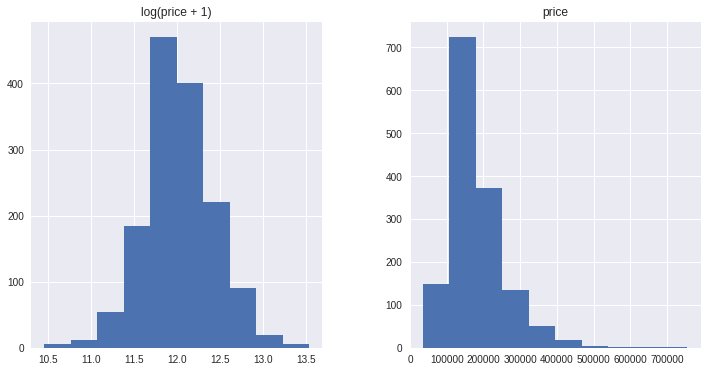

In [23]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":data_train["SalePrice"], "log(price + 1)":np.log1p(data_train["SalePrice"])})
prices.hist()

## Impute data

### Declarations

In [0]:
def check_data_missing_ratio(all_data):
  all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
  all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
  missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
  print(missing_data.head())

In [0]:
def fill_na_simple(all_data):
  all_data = pd.get_dummies(all_data)
  all_data = all_data.fillna(all_data.mean())
  return all_data

In [0]:
def fill_na_data_by_type(all_data):
  all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
  all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
  all_data["Alley"] = all_data["Alley"].fillna("None")
  all_data["Fence"] = all_data["Fence"].fillna("None")
  all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
  all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
  for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
      all_data[col] = all_data[col].fillna('None')
  for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
      all_data[col] = all_data[col].fillna(0)
  for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
      all_data[col] = all_data[col].fillna(0)
  for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
      all_data[col] = all_data[col].fillna('None')
  all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
  all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
  all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
  all_data = all_data.drop(['Utilities'], axis=1)
  all_data["Functional"] = all_data["Functional"].fillna("Typ")
  all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
  all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
  all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
  all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
  all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
  all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [0]:
def mark_col_categorical(all_data):
  #MSSubClass =The building class
  all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

  #Changing OverallCond into a categorical variable
  all_data['OverallCond'] = all_data['OverallCond'].astype(str)

  #Year and month sold are transformed into categorical features.
  all_data['YrSold'] = all_data['YrSold'].astype(str)
  all_data['MoSold'] = all_data['MoSold'].astype(str)

In [0]:
def label_cat_features(all_data):
  from sklearn.preprocessing import LabelEncoder
  cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
          'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
          'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
          'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
          'YrSold', 'MoSold')
  # Process columns and apply LabelEncoder to categorical features
  for c in cols:
      lbl = LabelEncoder() 
      lbl.fit(list(all_data[c].values)) 
      all_data[c] = lbl.transform(list(all_data[c].values))

In [0]:
def create_compound_feature(all_data):
  # Adding Total Square Feet feature 
  all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [0]:
def check_skewness(all_data):
  numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

  # Check the skew of all numerical features
  skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
  skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
  print(skewness.head())

In [0]:
def skew_data_set(all_data, normal_skew):
  numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

  # Check the skew of all numerical features
  skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
  skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
  
  # Only perform BC transformation on data set having large skewness
  skewness = skewness[abs(skewness) > normal_skew]
  print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

  from scipy.special import boxcox1p
  skewed_features = skewness.index
  lam = 0.15
  for feat in skewed_features:
      all_data[feat] = boxcox1p(all_data[feat], lam)
      all_data[feat] += 1

In [0]:
def plot_distribution(data_train):
  #Check the new distribution 
  sns.distplot(data_train['SalePrice'] , fit=norm);

  # Get the fitted parameters used by the function
  (mu, sigma) = norm.fit(data_train['SalePrice'])
  print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
  plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
              loc='best')
  plt.ylabel('Frequency')
  plt.title('SalePrice distribution')

  fig = plt.figure()
  res = stats.probplot(data_train['SalePrice'], plot=plt)
  plt.show()

  print("Skewness: %f" % data_train['SalePrice'].skew())
  print("Kurtosis: %f" % data_train['SalePrice'].kurt())

### Flow

In [33]:
simple_fill=True

print("===Before filling===")
check_data_missing_ratio(all_data)

if(simple_fill):
  all_data=fill_na_simple(all_data)
else:
  fill_na_data_by_type(all_data)

print("\n===After filling===")
check_data_missing_ratio(all_data)

===Before filling===
             Missing Ratio
PoolQC           99.657417
MiscFeature      96.402878
Alley            93.216855
Fence            80.438506
FireplaceQu      48.646797

===After filling===
Empty DataFrame
Columns: [Missing Ratio]
Index: []


In [34]:
print(all_data['MSSubClass'].describe())
print(all_data['MSSubClass'].unique())

count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40 150]


In [35]:
if(not simple_fill):
  mark_col_categorical(all_data)
  label_cat_features(all_data)
  create_compound_feature(all_data)

# Check shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 288)


In [0]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
all_result = np.log1p(all_result)

In [37]:
print("===Before BCTransform===")
check_skewness(all_data)

skew_data_set(all_data, 0.75)

print("\n===After BCTransform===")
check_skewness(all_data)

===Before BCTransform===
                     Skewed Features
Condition2_RRAn            54.000003
Exterior1st_ImStucc        54.000003
RoofMatl_Membran           54.000003
MiscFeature_TenC           54.000003
Condition2_RRAe            54.000003
There are 288 skewed numerical features to Box Cox transform

===After BCTransform===
                     Skewed Features
Condition2_RRAn            54.000003
RoofMatl_Membran           54.000003
Exterior1st_ImStucc        54.000003
Condition2_RRAe            54.000003
MiscFeature_TenC           54.000003


In [38]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 288)


## Prepare training and validation data

In [0]:
X_tr, X_val, y_tr, y_val = train_test_split(all_data, all_result, random_state = 3)

In [40]:
print(X_tr.shape)
print(X_val.shape)
print(y_tr.iloc[0])
print(y_val.iloc[0])

(2189, 288)
(730, 288)
11.997393966082265
11.970041217408847


In [0]:
def export_final_data():
    data_tr=pd.concat([X_tr, y_tr], axis=1)
    data_tr.to_csv('drive/CI-CA1/houseprices_full/train_proc.csv', sep=',')

    data_val=pd.concat([X_val, y_val], axis=1)
    data_tr.to_csv('drive/CI-CA1/houseprices_full/validation_proc.csv', sep=',')

In [0]:
#export_final_data()

# NN Models

## Declarations

In [0]:
# Regression chart.
def chart_regression(predArray,y,sort=True):
    t = pd.DataFrame({'pred' : predArray, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [0]:
def chart_score(results):
    t = pd.DataFrame({'rmse_tr' : results['rmse_tr'], 'rmse_val' : results['rmse_val']})
    a = plt.plot(t['rmse_val'].tolist(),label='RMSE Validation')
    b = plt.plot(t['rmse_tr'].tolist(),label='RMSE Training')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
    t = pd.DataFrame({'r2_tr' : results['r2_tr'], 'r2_val' : results['r2_val']})
    a = plt.plot(t['r2_val'].tolist(),label='R2 Validation')
    b = plt.plot(t['r2_tr'].tolist(),label='R2 Training')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [0]:
def chart_epoch(results):
    t = pd.DataFrame({'stopped_epoch' : results['stopped_epoch']})
    a = plt.plot(t['stopped_epoch'].tolist(),label='Stopped epoch')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [0]:
# Regression chart.
def chart_single(y,sort=True):
    t = pd.DataFrame({'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [0]:
def prediction_report(model, predArray, X_data, y_data):
  #Fill Nan cell with 0
  pred_fill=pd.Series(predArray)
  pred_fill=pred_fill.fillna(0)
    
  #RMSE score
  score = np.sqrt(metrics.mean_squared_error(pred_fill,y_data))
  print("Score (RMSE): {}".format(score))

  #R2 score  
  score_r2 = r2_score(y_data, pred_fill)
  print("Score (R2): {}".format(score_r2))

  chart_regression(predArray,y_data)
  chart_regression(predArray,y_data,False)

In [0]:
def caculate_score(predArray, y_data):
  #Fill Nan cell with 0
  pred_fill=pd.Series(predArray)
  pred_fill=pred_fill.fillna(0)

  #RMSE score
  score = np.sqrt(metrics.mean_squared_error(pred_fill,y_data))
  #print("Score (RMSE): {}".format(score))

  #R2 score  
  score_r2 = r2_score(y_data, pred_fill)
  #print("Score (R2): {}".format(score_r2))
  return score, score_r2

## MLP (keras)

** Chracteristics **

In [0]:
def run_mlp(node_count, layer_count):
    mlp = Sequential()
    mlp.add(Dense(node_count, input_dim=X_tr.shape[1], activation='relu'))
    for layer in range(2,layer_count+1):
        mlp.add(Dense(node_count, activation='relu'))
    
    mlp.add(Dense(1, activation='linear'))
    # Compile model
    mlp.compile(loss='mean_squared_error', optimizer='adam')

    epochs = 1000
    # Fit the model
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
    hist = mlp.fit(X_tr, y_tr,
                   epochs=epochs,
                   verbose=0,
                   validation_data=(X_val, y_val),
                   callbacks=[monitor])

    pred_mlp_tr = mlp.predict(X_tr)
    score_tr, score_r2_tr = caculate_score(pred_mlp_tr[:,0], y_tr)

    pred_mlp_val = mlp.predict(X_val)
    score_val, score_r2_val = caculate_score(pred_mlp_val[:,0], y_val)

    result = pd.DataFrame([[node_count, monitor.stopped_epoch, score_tr, score_r2_tr, score_val, score_r2_val]],\
                      columns=['nodes', 'stopped_epoch', 'rmse_tr', 'r2_tr', 'rmse_val', 'r2_val'])
    return mlp, result

In [0]:
def run_mlp_step(node_count, layer_count):
    mlp = Sequential()
    mlp.add(Dense(node_count, input_dim=X_tr.shape[1], activation='relu'))
    for layer in range(2,layer_count+1):
        mlp.add(Dense(node_count, activation='relu'))
    mlp.add(Dense(79, activation='relu'))
    mlp.add(Dense(1, activation='linear'))
    # Compile model
    mlp.compile(loss='mean_squared_error', optimizer='adam')

    epochs = 1000
    # Fit the model
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
    hist = mlp.fit(X_tr, y_tr,
                   epochs=epochs,
                   verbose=0,
                   validation_data=(X_val, y_val),
                   callbacks=[monitor])

    pred_mlp_tr = mlp.predict(X_tr)
    score_tr, score_r2_tr = caculate_score(pred_mlp_tr[:,0], y_tr)

    pred_mlp_val = mlp.predict(X_val)
    score_val, score_r2_val = caculate_score(pred_mlp_val[:,0], y_val)

    result = pd.DataFrame([[node_count, monitor.stopped_epoch, score_tr, score_r2_tr, score_val, score_r2_val]],\
                      columns=['nodes', 'stopped_epoch', 'rmse_tr', 'r2_tr', 'rmse_val', 'r2_val'])
    return mlp, result

In [0]:
def get_result_desc(result, key, name):
    df = pd.DataFrame([[name,
                        result[key].mean(), result[key].min(),\
                        result[key].max(), result[key].std()]],
                      columns=['regressor', key+'.mean',key+'.min',key+'.max',key+'.std'])
    return df

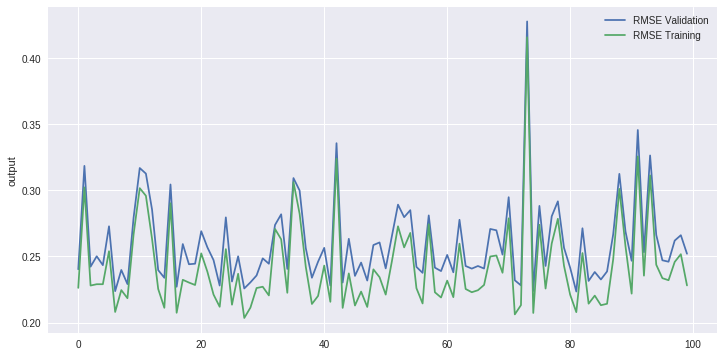

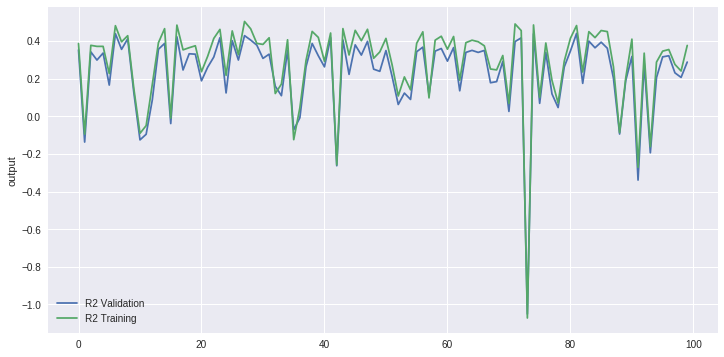

In [51]:
results_mlp_1=pd.DataFrame(columns=['nodes', 'stopped_epoch', 'rmse_tr', 'r2_tr', 'rmse_val', 'r2_val'])
rmse_mlp_1_val_min=1

for node_count in np.arange(100, 200, 1):
    mlp_1, result = run_mlp(node_count, 1)
    results_mlp_1 = results_mlp_1.append(result, ignore_index=True)
    if(result['rmse_val'].iat[0] < rmse_mlp_1_val_min):
        best_mlp_1=mlp_1
        rmse_mlp_1_val_min=result['rmse_val'].iat[0]

chart_score(results_mlp_1)

In [52]:
print(results_mlp_1.describe())

          rmse_tr       r2_tr    rmse_val      r2_val
count  100.000000  100.000000  100.000000  100.000000
mean     0.242213    0.283288    0.259730    0.232278
std      0.033411    0.222469    0.031965    0.210767
min      0.203517   -1.071758    0.223500   -1.050415
25%      0.220523    0.214848    0.239506    0.163917
50%      0.231023    0.360027    0.249349    0.302864
75%      0.255890    0.416886    0.273071    0.356823
max      0.415668    0.503353    0.427634    0.439915


count     100
unique     28
top        23
freq       11
Name: stopped_epoch, dtype: int64


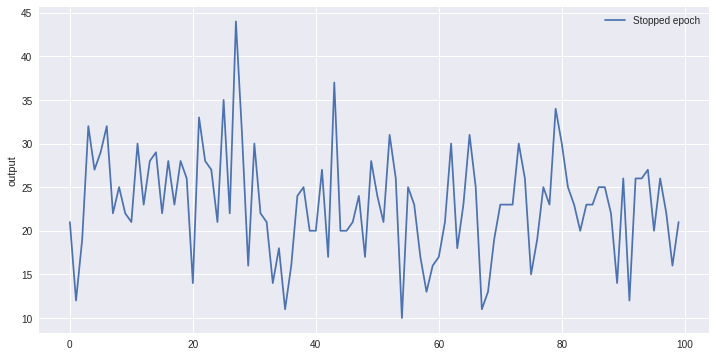

In [53]:
print(results_mlp_1['stopped_epoch'].describe())
chart_epoch(results_mlp_1)

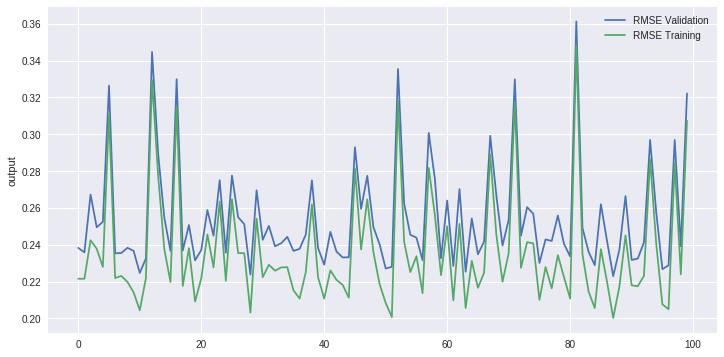

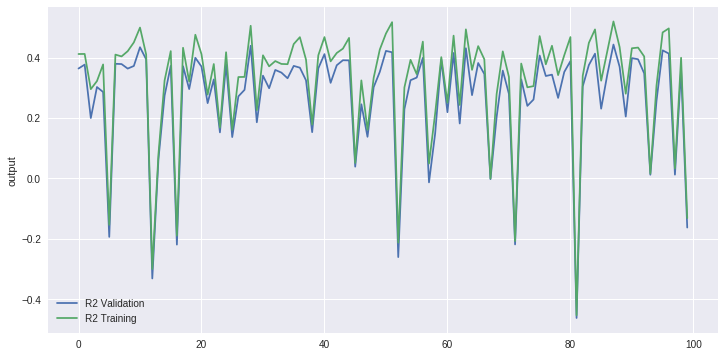

In [54]:
results_mlp_2=pd.DataFrame(columns=['nodes', 'stopped_epoch', 'rmse_tr', 'r2_tr', 'rmse_val', 'r2_val'])
rmse_mlp_2_val_min=1

for node_count in np.arange(100, 200, 1):
    mlp_2, result = run_mlp(node_count, 2)
    results_mlp_2 = results_mlp_2.append(result, ignore_index=True)
    if(result['rmse_val'].iat[0] < rmse_mlp_2_val_min):
        best_mlp_2=mlp_2
        rmse_mlp_2_val_min=result['rmse_val'].iat[0]

chart_score(results_mlp_2)

In [55]:
print(results_mlp_2.describe())

          rmse_tr       r2_tr    rmse_val      r2_val
count  100.000000  100.000000  100.000000  100.000000
mean     0.236400    0.318784    0.253981    0.267421
std      0.030601    0.192488    0.028957    0.181581
min      0.200199   -0.453968    0.222903   -0.463005
25%      0.217825    0.299265    0.235769    0.229993
50%      0.225969    0.387729    0.243336    0.336086
75%      0.241743    0.431069    0.262059    0.376736
max      0.348221    0.519417    0.361222    0.442903


count     100
unique     20
top        11
freq       11
Name: stopped_epoch, dtype: int64


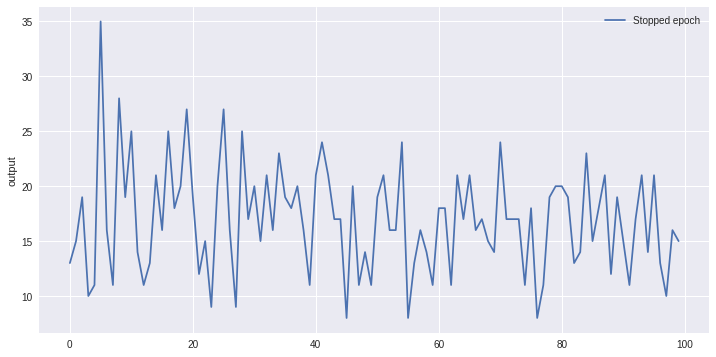

In [56]:
print(results_mlp_2['stopped_epoch'].describe())
chart_epoch(results_mlp_2)

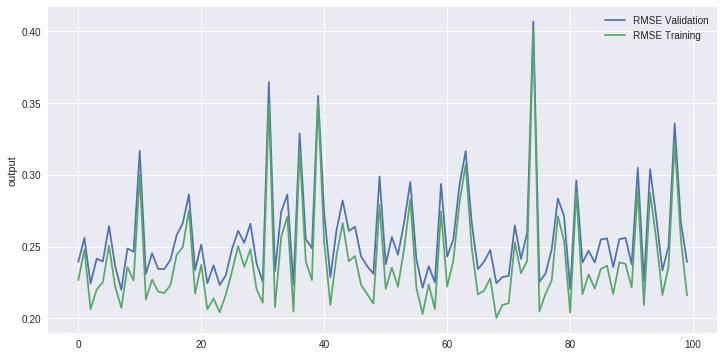

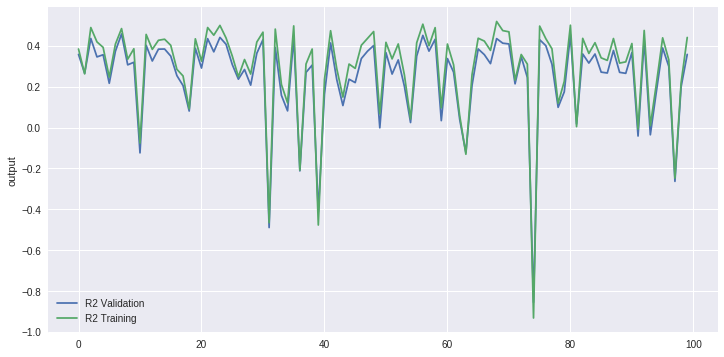

In [57]:
results_mlp_3=pd.DataFrame(columns=['nodes', 'stopped_epoch', 'rmse_tr', 'r2_tr', 'rmse_val', 'r2_val'])
rmse_mlp_3_val_min=1

for node_count in np.arange(100, 200, 1):
    mlp_3, result = run_mlp(node_count, 3)
    results_mlp_3 = results_mlp_3.append(result, ignore_index=True)
    if(result['rmse_val'].iat[0] < rmse_mlp_3_val_min):
        best_mlp_3=mlp_3
        rmse_mlp_3_val_min=result['rmse_val'].iat[0]

chart_score(results_mlp_3)

In [58]:
print(results_mlp_3.describe())

          rmse_tr       r2_tr    rmse_val      r2_val
count  100.000000  100.000000  100.000000  100.000000
mean     0.239961    0.294870    0.256649    0.249369
std      0.035175    0.232296    0.032994    0.214049
min      0.200280   -0.932300    0.219883   -0.855586
25%      0.216949    0.247997    0.235422    0.205866
50%      0.229224    0.369944    0.247852    0.311214
75%      0.250430    0.435632    0.266133    0.378565
max      0.401434    0.519026    0.406810    0.457898


count     100
unique     16
top        13
freq       16
Name: stopped_epoch, dtype: int64


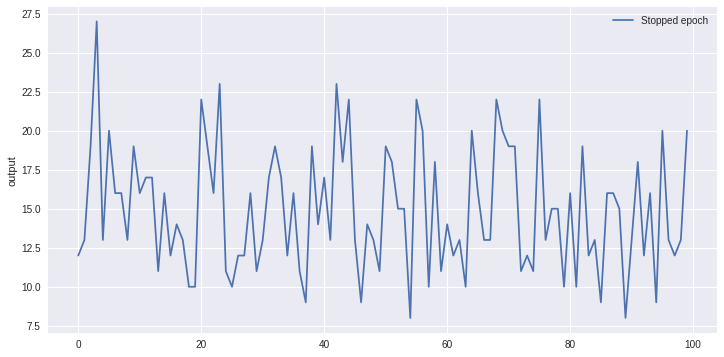

In [59]:
print(results_mlp_3['stopped_epoch'].describe())
chart_epoch(results_mlp_3)

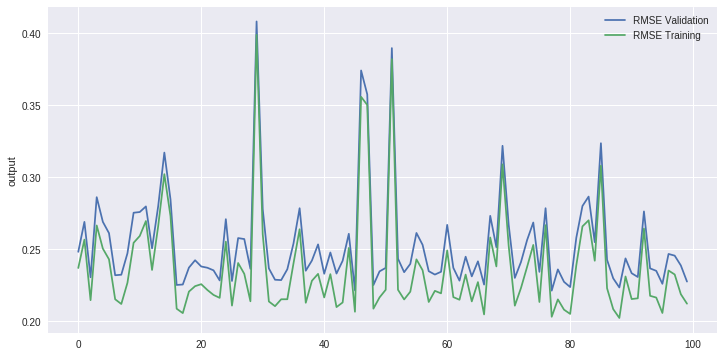

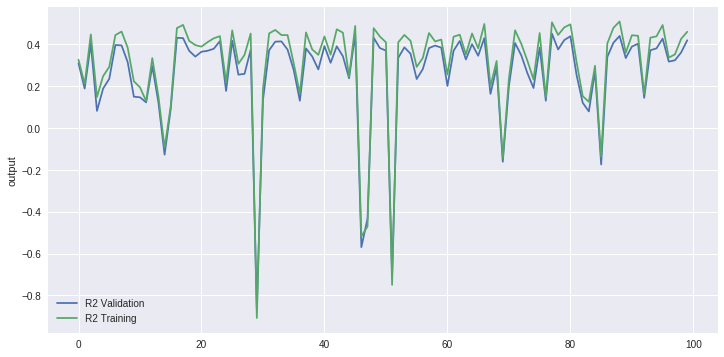

In [60]:
results_mlp_4=pd.DataFrame(columns=['nodes', 'stopped_epoch', 'rmse_tr', 'r2_tr', 'rmse_val', 'r2_val'])
rmse_mlp_4_val_min=1

for node_count in np.arange(100, 200, 1):
    mlp_4, result = run_mlp_step(node_count, 1)
    results_mlp_4 = results_mlp_4.append(result, ignore_index=True)
    if(result['rmse_val'].iat[0] < rmse_mlp_4_val_min):
        best_mlp_4=mlp_4
        rmse_mlp_4_val_min=result['rmse_val'].iat[0]

chart_score(results_mlp_4)

In [61]:
print(results_mlp_4.describe())

          rmse_tr       r2_tr    rmse_val      r2_val
count  100.000000  100.000000  100.000000  100.000000
mean     0.236919    0.311419    0.253646    0.265519
std      0.036175    0.243950    0.034374    0.228391
min      0.202182   -0.907688    0.221168   -0.867762
25%      0.214769    0.247731    0.232995    0.201440
50%      0.223630    0.400332    0.242006    0.343326
75%      0.250475    0.446921    0.266873    0.391315
max      0.398870    0.509850    0.408143    0.451543


count     100
unique     20
top        18
freq       13
Name: stopped_epoch, dtype: int64


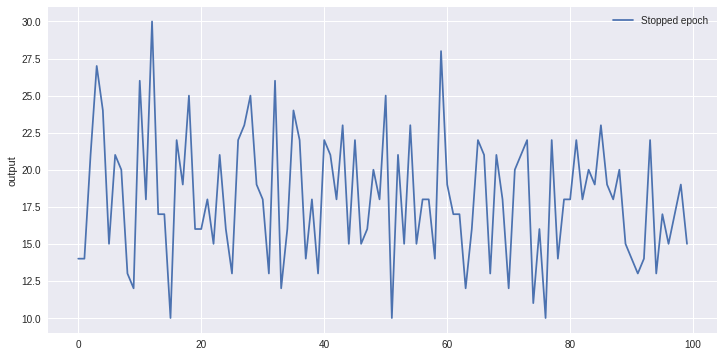

In [62]:
print(results_mlp_4['stopped_epoch'].describe())
chart_epoch(results_mlp_4)

** Summary **

In [76]:
key = 'rmse_val'
df_rmse = pd.DataFrame(columns=['regressor', key+'.mean',key+'.min',key+'.max',key+'.std'])
df = get_result_desc(results_mlp_1, key, 'MLPR(X)')
df_rmse = df_rmse.append(df, ignore_index=True)

df = get_result_desc(results_mlp_4, key, 'MLPR(X,79)')
df_rmse = df_rmse.append(df, ignore_index=True)

df = get_result_desc(results_mlp_2, key, 'MLPR(X,X)')
df_rmse = df_rmse.append(df, ignore_index=True)

df = get_result_desc(results_mlp_3, key, 'MLPR(X,X,X)')
df_rmse = df_rmse.append(df, ignore_index=True)
df_rmse

,regressor,rmse_val.mean,rmse_val.min,rmse_val.max,rmse_val.std
0,MLPR(X),0.259730,0.223500,0.427634,0.031965
1,"MLPR(X,79)",0.253646,0.221168,0.408143,0.034374
2,"MLPR(X,X)",0.253981,0.222903,0.361222,0.028957
3,"MLPR(X,X,X)",0.256649,0.219883,0.406810,0.032994


In [77]:
key = 'stopped_epoch'
df_epoch = pd.DataFrame(columns=['regressor', key+'.mean',key+'.min',key+'.max',key+'.std'])
df = get_result_desc(results_mlp_1, key, 'MLPR(X)')
df_epoch = df_epoch.append(df, ignore_index=True)

df = get_result_desc(results_mlp_4, key, 'MLPR(X,79)')
df_epoch = df_epoch.append(df, ignore_index=True)

df = get_result_desc(results_mlp_2, key, 'MLPR(X,X)')
df_epoch = df_epoch.append(df, ignore_index=True)

df = get_result_desc(results_mlp_3, key, 'MLPR(X,X,X)')
df_epoch = df_epoch.append(df, ignore_index=True)
df_epoch

,regressor,stopped_epoch.mean,stopped_epoch.min,stopped_epoch.max,stopped_epoch.std
0,MLPR(X),23.09,10,44,6.110258
1,"MLPR(X,79)",18.15,10,30,4.281449
2,"MLPR(X,X)",16.94,8,35,4.927392
3,"MLPR(X,X,X)",14.92,8,27,3.996665


** Highlights **

In [0]:
def run_single_mlp(node_count, layer_count):
    mlp = Sequential()
    mlp.add(Dense(node_count, input_dim=X_tr.shape[1], activation='relu'))
    for layer in range(2,layer_count+1):
        mlp.add(Dense(node_count, activation='relu'))
    
    mlp.add(Dense(1, activation='linear'))
    # Compile model
    mlp.compile(loss='mean_squared_error', optimizer='adam')
    mlp.summary()

    epochs = 1000
    # Fit the model
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    hist = mlp.fit(X_tr, y_tr,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(X_val, y_val),
                   callbacks=[monitor])

    pred_mlp_tr = mlp.predict(X_tr)
    prediction_report(mlp, pred_mlp_tr[:,0], X_tr, y_tr)

    pred_mlp_val = mlp.predict(X_val)
    prediction_report(mlp, pred_mlp_val[:,0], X_val, y_val)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1201 (Dense)           (None, 100)               28900     
_________________________________________________________________
dense_1202 (Dense)           (None, 100)               10100     
_________________________________________________________________
dense_1203 (Dense)           (None, 1)                 101       
Total params: 39,101
Trainable params: 39,101
Non-trainable params: 0
_________________________________________________________________
Train on 2189 samples, validate on 730 samples
Epoch 1/1000
2189/2189 [==============================] - 27s 12ms/step - loss: 9.1614 - val_loss: 0.1822
Epoch 2/1000
2189/2189 [==============================] - 1s 435us/step - loss: 0.1527 - val_loss: 0.1180
Epoch 3/1000
2189/2189 [==============================] - 1s 432us/step - loss: 0.0935 - val_loss: 0.0795
Epoch 4/1000
2189/2189 [=============

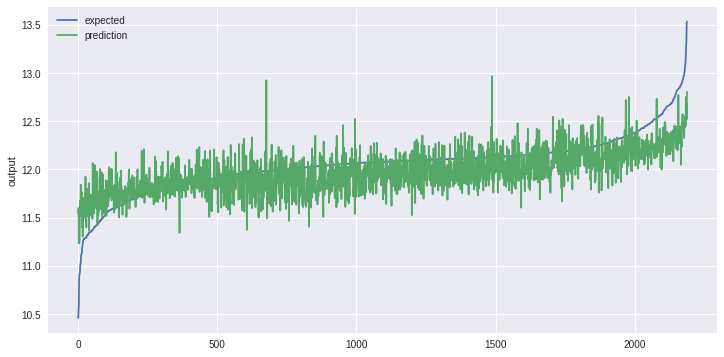

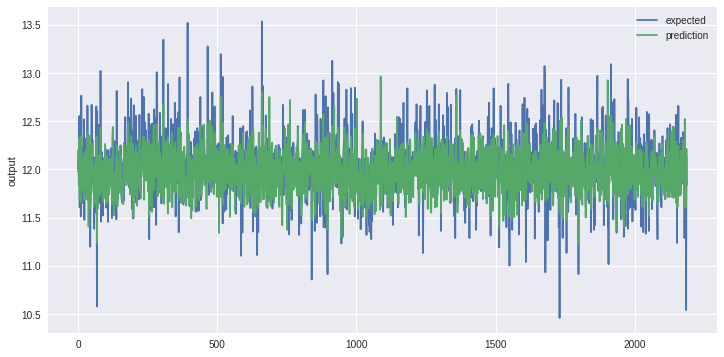

Score (RMSE): 0.23809581464941257
Score (R2): 0.36437453238015705


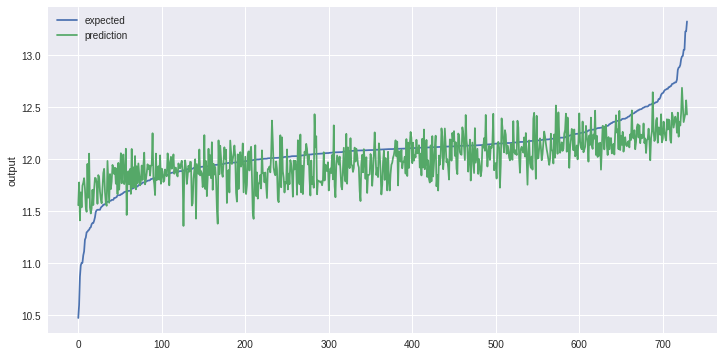

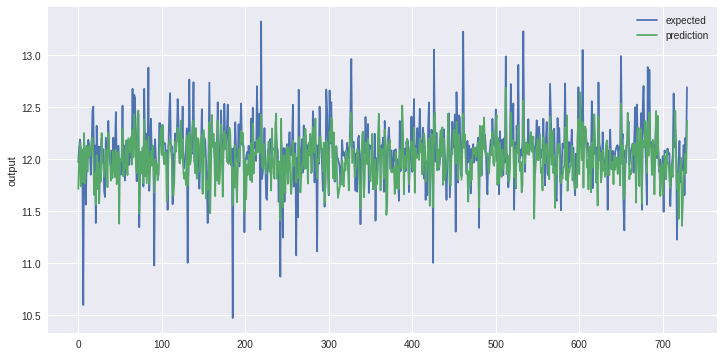

In [64]:
run_single_mlp(100, 2)

# Best Models

## Declarations

In [0]:
def mlp_prediction(mlp):
  pred_mlp_tr = mlp.predict(X_tr)
  prediction_report(mlp, pred_mlp_tr[:,0], X_tr, y_tr)

  pred_mlp_val = mlp.predict(X_val)
  prediction_report(mlp, pred_mlp_val[:,0], X_val, y_val)

## Model details


Best MLP - (X)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_163 (Dense)            (None, 181)               52309     
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 182       
Total params: 52,491
Trainable params: 52,491
Non-trainable params: 0
_________________________________________________________________
None
Score (RMSE): 0.20792025693279997
Score (R2): 0.481630840108776


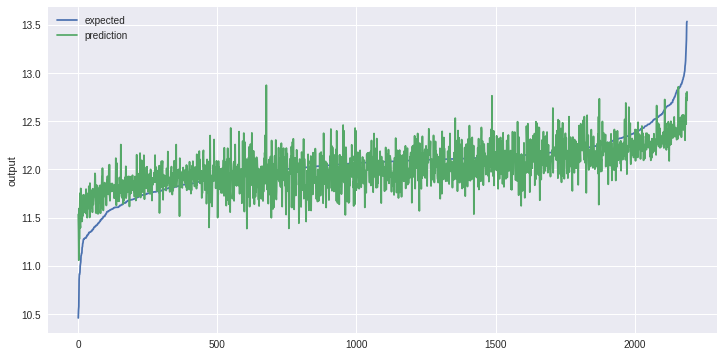

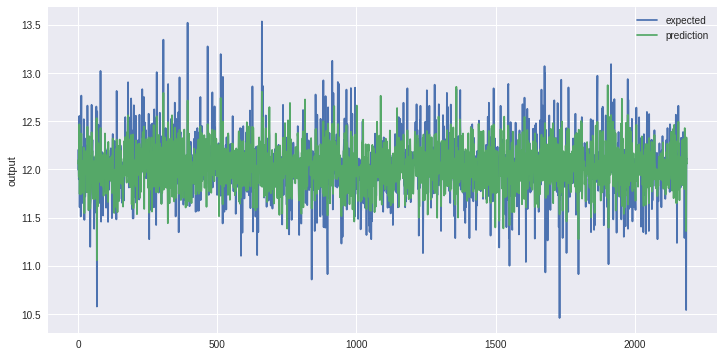

Score (RMSE): 0.22350019916541375
Score (R2): 0.4399154455614859


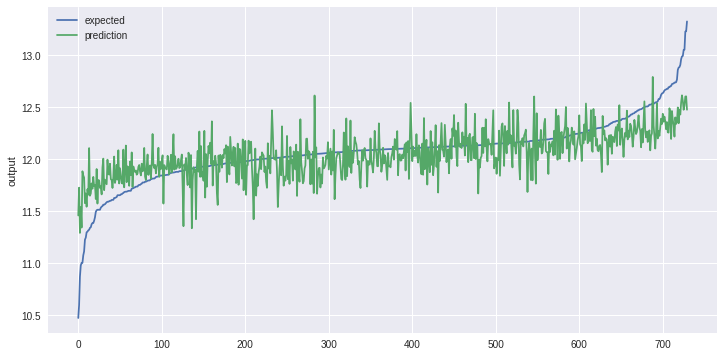

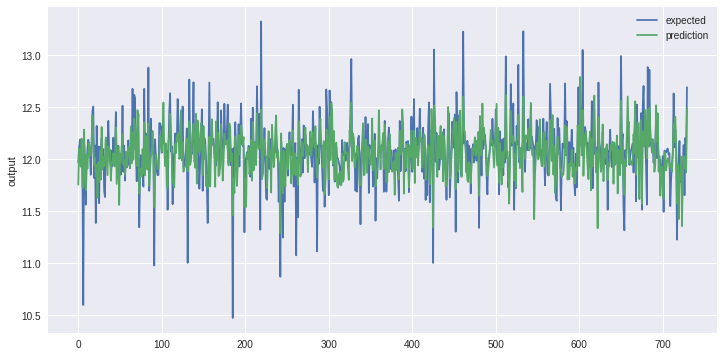

In [66]:
print("\nBest MLP - (X)\n")
print(best_mlp_1.summary())
mlp_prediction(best_mlp_1)


Best MLP - (X,X)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_462 (Dense)            (None, 187)               54043     
_________________________________________________________________
dense_463 (Dense)            (None, 187)               35156     
_________________________________________________________________
dense_464 (Dense)            (None, 1)                 188       
Total params: 89,387
Trainable params: 89,387
Non-trainable params: 0
_________________________________________________________________
None
Score (RMSE): 0.20019885177433366
Score (R2): 0.5194166573862673


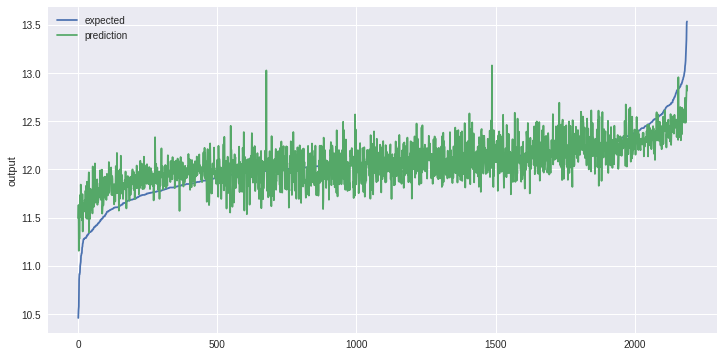

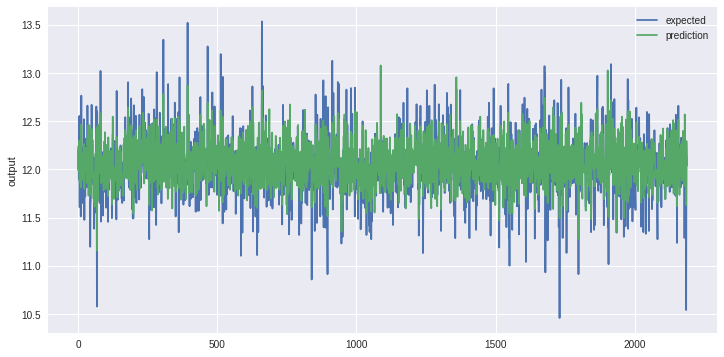

Score (RMSE): 0.22290330238308764
Score (R2): 0.44290306032951454


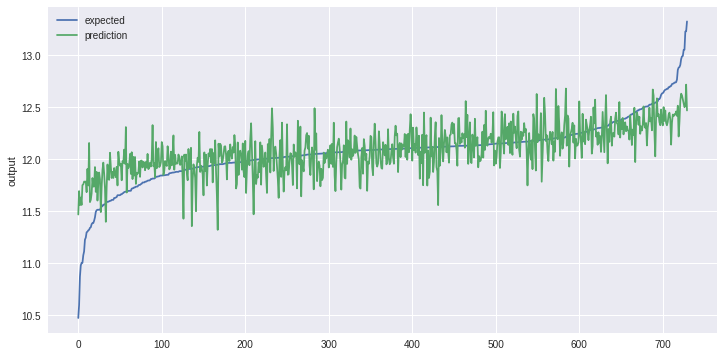

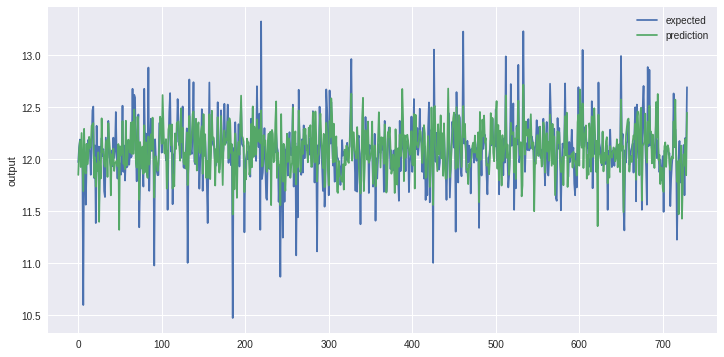

In [67]:
print("\nBest MLP - (X,X)\n")
print(best_mlp_2.summary())
mlp_prediction(best_mlp_2)


Best MLP - (X,X,X)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_529 (Dense)            (None, 107)               30923     
_________________________________________________________________
dense_530 (Dense)            (None, 107)               11556     
_________________________________________________________________
dense_531 (Dense)            (None, 107)               11556     
_________________________________________________________________
dense_532 (Dense)            (None, 1)                 108       
Total params: 54,143
Trainable params: 54,143
Non-trainable params: 0
_________________________________________________________________
None
Score (RMSE): 0.20741194498689414
Score (R2): 0.4841623024434014


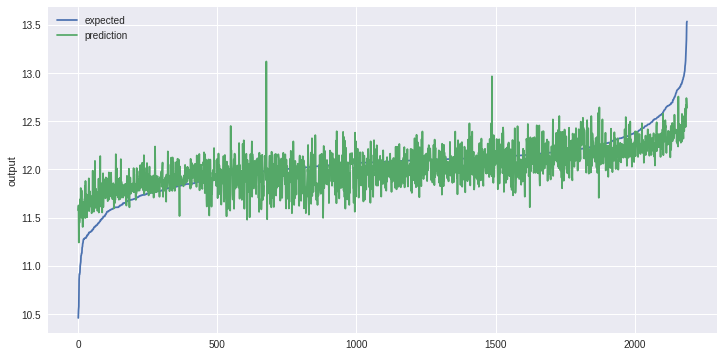

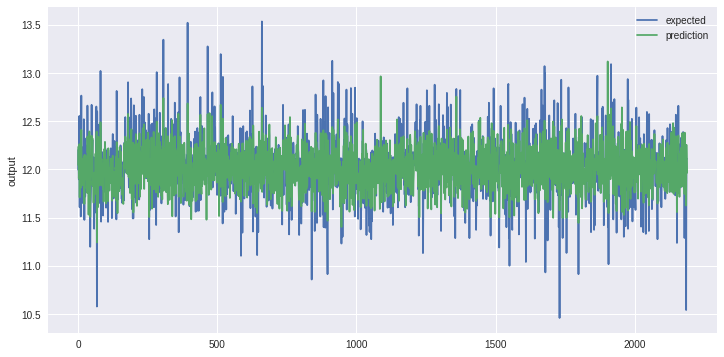

Score (RMSE): 0.21988291516643269
Score (R2): 0.45789833706668814


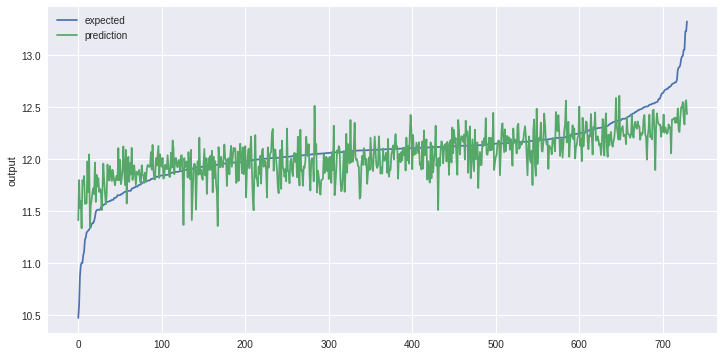

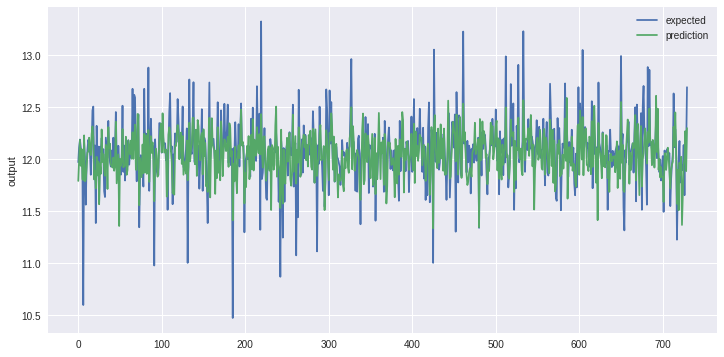

In [68]:
print("\nBest MLP - (X,X,X)\n")
print(best_mlp_3.summary())
mlp_prediction(best_mlp_3)


Best MLP - (X,79)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1132 (Dense)           (None, 177)               51153     
_________________________________________________________________
dense_1133 (Dense)           (None, 79)                14062     
_________________________________________________________________
dense_1134 (Dense)           (None, 1)                 80        
Total params: 65,295
Trainable params: 65,295
Non-trainable params: 0
_________________________________________________________________
None
Score (RMSE): 0.20301788460864106
Score (R2): 0.5057870221360776


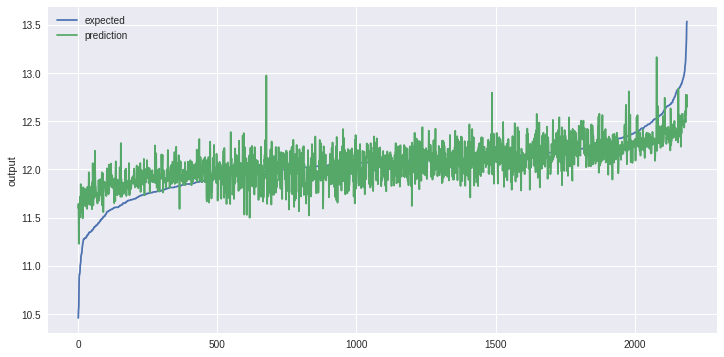

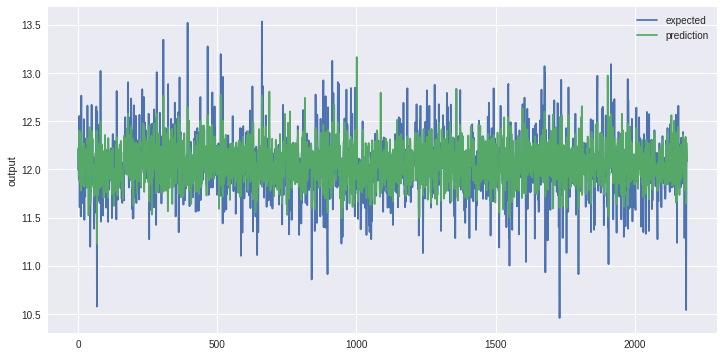

Score (RMSE): 0.22116816018597202
Score (R2): 0.45154250253600536


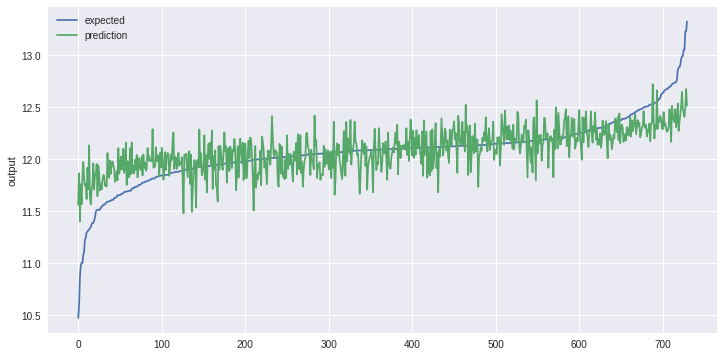

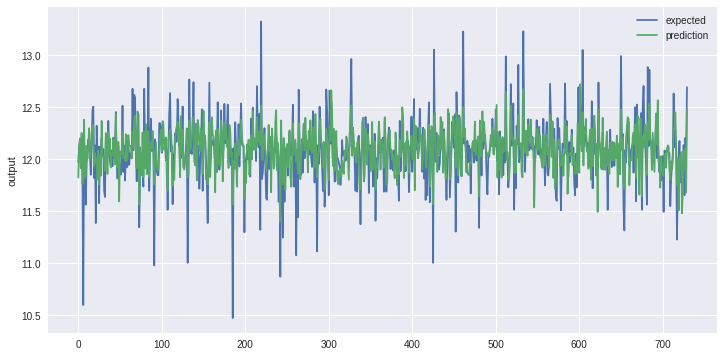

In [69]:
print("\nBest MLP - (X,79)\n")
print(best_mlp_4.summary())
mlp_prediction(best_mlp_4)

## Save models

In [0]:
best_mlp_1.save('drive/CI-CA1/houseprices_full/best_mlp_1.h5')
best_mlp_2.save('drive/CI-CA1/houseprices_full/best_mlp_2.h5')
best_mlp_3.save('drive/CI-CA1/houseprices_full/best_mlp_3.h5')
best_mlp_4.save('drive/CI-CA1/houseprices_full/best_mlp_4.h5')